# Concrete Fracture Detection with Supervised Learning
### Feature Extraction: Set of 4 Hashing Methods from ImageHash Library
### Classifier: Selected from 17 classifiers in scikit-learn Library
### Feature Selection: Sequential Feature Selection method from scikit-learn Library

### AUTHORS: JOSE HIDALGO, PhD,  DIEGO FRIAS, PhD and Bel. DOUGLAS SANTOS.

Image hashes tell whether two images look nearly identical. This is different from cryptographic hashing algorithms (like MD5, SHA-1) where tiny changes in the image give completely different hashes. In image fingerprinting, we actually want our similar inputs to have similar output hashes as well.

ImageHash supports:

1. Average hashing
2. Perceptual hashing
3. Difference hashing 
4. Wavelet hashing 
5. HSV color hashing

The image hash algorithms (average, perceptual, difference, wavelet) analyse the image structure on luminance (without color information). The color hash algorithm analyses the color distribution and black & gray fractions (without position information).

Our image pre-processing consists in the following steps:
a) Image conversion to gray scale
b) Filtering by threshold with threshold estimated automatically by the OTSU method
c) Calculation of (1) Average, (2) Perceptual, (3) Difference, (4) Wavelet Haar and (5) Wavelet db4 filtered image hashes
d) Calculation of Z-transformed images from the filtered images
e) Calculation of (1) Average, (2) Perceptual, (3) Difference, (4) Wavelet Haar and (5) Wavelet db4 hashes of Z-images
f) Feature normalization using the MinMaxscaler method

The result of the pre-processing step is the construction of a dataset with 10 features (hashes) for each image. 

After preprocessing the selection of the classifier is done by k-fold cross validation considering the following methods:
1. Logistic Regression
2. Ridge Classifier
3. SGD Classifier
4. Passive Aggressive Classifier
5. KNeighbors Classifier
6. Decision Tree Classifier
7. Extra Tree Classifier
8. Linear SVC
9. SVC
10. Gaussian NB
11. AdaBoost Classifier
12. Bagging Classifier
13. Random Forest Classifier
14. Extra Trees Classifier
15. Gradient Boosting Classifier
16. Linear Discriminant Analysis
17. Quadratic Discriminant Analysis



In [37]:
%matplotlib inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN, KMeans

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import  classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

import seaborn as sns
sns.set()

from PIL import Image

import imagehash

import numpy as np
from numpy import mean
from numpy import isnan
from numpy import asarray
from numpy import polyfit

import statistics

import os
import shutil, glob, os.path

from random import shuffle

from tqdm import tqdm

from scipy.stats import pearsonr

import math

import skimage
from skimage import data, io, color
from skimage.filters import threshold_otsu 
from skimage.feature import canny 


In [2]:
POSITIVE_PATH = 'C:/Users/diego/OneDrive/Documentos/NOTEBOOKS/IA/Concrete/Positive'
NEGATIVE_PATH = 'C:/Users/diego/OneDrive/Documentos/NOTEBOOKS/IA/Concrete/Negative'

PosFiles=os.listdir(POSITIVE_PATH)
NegFiles=os.listdir(NEGATIVE_PATH)

nPosImg=len(PosFiles)
nNegImg=len(NegFiles)

print("number of positive images: ",nPosImg,"number of negative images: ",nNegImg)

number of positive images:  20000 number of negative images:  20000


In [3]:
HNSAMPLES=10000 # number of samples of each class (balanced dataset always)
if HNSAMPLES>nPosImg or HNSAMPLES>nNegImg:
    HNSAMPLES=np.min(nPosImg,nNegImg)
    
INT_LENGTH = 16

In [4]:
# FUNCTIONS FOR HASING IMAGES USING IMAGEHASH LIBRARY

hashfuncs = [
    ('ahash', imagehash.average_hash),
    ('phash', imagehash.phash),
    ('dhash', imagehash.dhash),
    ('whash-haar',lambda img: imagehash.whash(img, mode='haar')), # imagehash.whash),
    ('whash-db4', lambda img: imagehash.whash(img, mode='db4')), # very large hash without z-transform
  #  ('colorhash', imagehash.colorhash), not classificatory with non-color-images as gray-scale concrete images
]

nhash=len(hashfuncs)
print("number of hash functions:", nhash)

concrete_features=['avg_hash','perc_hash','diff_hash','wvl_haar_hash','wvl_db4_hash',\
                   'z-transf+avg_hash','z-transf+perc_hash','z-transf+diff_hash','z-transf+wvl_haar_hash','z-transf+wvl_db4_hash']
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def alpharemover(image):
    if image.mode != 'RGBA':
        return image
    canvas = Image.new('RGBA', image.size, (255,255,255,255))
    canvas.paste(image, mask=image)
    return canvas.convert('RGB')

def image_loader(hashfunc, hash_size=8):
    def function(path):
#         image = Image.open(path) 3 load in format Image
        # new - threshold filtering
        image = io.imread(path) # load image in np.array
        if image.shape[2]>=3: # if RGB or similar
            image = color.rgb2gray(image) # transform to grayscale 
        threshold_value = threshold_otsu(image)  # using OTSU method to fin optimal threshold for image
        Img = image > threshold_value  # filtering the image
        return hashfunc(Image.fromarray(Img)) # return hash of the image, previously transformed to Image format from array
    return function

def with_ztransform_preprocess(hashfunc, hash_size=8):
    def function(path):
        image = alpharemover(Image.open(path))
        image = image.convert("L").resize((hash_size, hash_size), Image.ANTIALIAS)
        data = image.getdata()
        quantiles = np.arange(100)
        quantiles_values = np.percentile(data, quantiles)
        zdata = (np.interp(data, quantiles_values, quantiles) / 100 * 255).astype(np.uint8)
        image.putdata(zdata)
        return hashfunc(image)
    return function

# PIPELINE SCRIPT FOR EACH FILE:
#1. lOAD IMAGE FROM FILE, 
#2. CORRECT NON-RGBA IMAGES, 
#3. APPLY HASH FUNCTIONS DIRECTLY & 
#4. PREPROCESS IMAGES WITH Z-TRANSFORM AND APPLY HASH FUNCTIONS 

HashFuncCallers = [(name, image_loader(func)) for name, func in hashfuncs]
HashFuncCallers += [(name + '-z', with_ztransform_preprocess(func)) for name, func in hashfuncs if name != 'colorhash']


number of hash functions: 5


In [5]:
# threshold_value = threshold_otsu(camera)  

# camera_threholded = camera > threshold_value  

# # Show the original image
# io.imshow(camera)
# plt.show()

# # Show the thresholded image
# io.imshow(camera_threholded)
# plt.show()

# # edges
# coins = color.rgb2gray(coins) 
 
# # Apply Canny detector 
# coins_edges = canny(coins) 

# io.imshow(coins)
# plt.show()

# io.imshow(coins_edges)
# plt.show()

In [6]:
# create training data set

# features are obtained applying all hashing arsenal, with and without z-transform plus threshold filtering

Xpos=[]
Ypos=[]
for file in tqdm(PosFiles[:HNSAMPLES]):
    path=os.path.join(POSITIVE_PATH, file)
    Ypos.append(1)
    Xpos.append([])
    Xpos[-1].append([(HashFuncCallers(path)) for name, HashFuncCallers in HashFuncCallers])

xpos=np.array(Xpos).reshape(np.asarray(Xpos).shape[0],np.asarray(Xpos).shape[2])
# print(path, ',',xpos.shape)

print()
Xneg=[]
Yneg=[]
for file in tqdm(NegFiles[:HNSAMPLES]):
    path=os.path.join(NEGATIVE_PATH, file)
    Yneg.append(0)
    Xneg.append([])
    Xneg[-1].append([(HashFuncCallers(path)) for name, HashFuncCallers in HashFuncCallers])

xneg=np.array(Xneg).reshape(np.asarray(Xneg).shape[0],np.asarray(Xneg).shape[2])

x=np.concatenate((xpos,xneg))

nfeat=x.shape[1]
nSamples=x.shape[0]

print("nSamples: ",nSamples)
print('dataset shape: ',x.shape)

Y=np.concatenate((Ypos,Yneg))
print('target shape: ',Y.shape)


  0%|                                                                                | 4/10000 [00:00<04:44, 35.17it/s]

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:54<00:00, 28.24it/s]


nSamples:  20000
dataset shape:  (20000, 10)
target shape:  (20000,)


In [7]:
print('data set type:', type(x),', dataset matrix shape:', x.shape, ', dataset element type:',type(x[-1][-1]))
print('feat 7o dataset element 5 in float format:', float(int(str(x[5][7]),16)))
for s in range(1): #nSamples):
    print('dataset element in binary format:',bin(int(str(x[5][0]),16)))
print(3*int(bin(int(str(x[-1][0]),16))[3]))

data set type: <class 'numpy.ndarray'> , dataset matrix shape: (20000, 10) , dataset element type: <class 'imagehash.ImageHash'>
feat 7o dataset element 5 in float format: 3.721845649481066e+18
dataset element in binary format: 0b1111101111110011111100111111001111110011111100111111001111111011
0


In [8]:
# transformation of image hash dataset into float matrix
X=np.zeros((nSamples,nfeat),dtype=float)
for s in range(nSamples):
    for f in range(nfeat):
        X[s,f]=float(int(str(x[s,f]),16))

scaler=MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)        

#adding edges
#importing the required libraries
# import numpy as np
# from skimage.io import imread, imshow
# from skimage.filters import prewitt_h,prewitt_v
# import matplotlib.pyplot as plt
# %matplotlib inline

# #reading the image 
# image = imread('puppy.jpeg',as_gray=True)

# #calculating horizontal edges using prewitt kernel
# edges_prewitt_horizontal = prewitt_h(image)
# #calculating vertical edges using prewitt kernel
# edges_prewitt_vertical = prewitt_v(image)

# imshow(edges_prewitt_vertical, cmap='gray')
        
# X=normalize(X)

In [9]:
# SELECTING ONLY FEATURES WITHOUT Z-TRANSFORM
# x=X[:,nhash:]
# print(x.shape)

In [10]:
# # split dataset into training and testing data
# # change random seed to generate different datasets
# test_size=0.3
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

> FEATURE SELECTION WITH PCA METHOD
>> DID NOT WORKED WELL

In [11]:
# FEATURE TRANSFORMATION USING PRINCIPAL COMPONENT ANALYSIS (PCA) 

# n_components='mle' # or 3 like above

# pca=PCA(n_components=n_components).fit(X)

# X_pca = pca.transform(X)

# n_components=X_pca.shape[1]
# print("number of selected PCA directions:",n_components)
# # plot the first three PCA dimensions

# fig4 = plt.figure(1, figsize=(8, 6))
# ax4 = Axes3D(fig4, elev=-150, azim=110)
# ax4.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=Y, cmap=plt.cm.Set1, edgecolor='k', s=40)
# ax4.set_title("First "+str(n_components)+" PCA directions")
# ax4.set_xlabel("1st eigenvector")
# ax4.set_ylabel("2nd eigenvector")
# ax4.set_zlabel("3rd eigenvector")

# plt.show()

# print("component importance 1: ",pca.explained_variance_ratio_)
# print("component importance 2: ",pca.singular_values_)

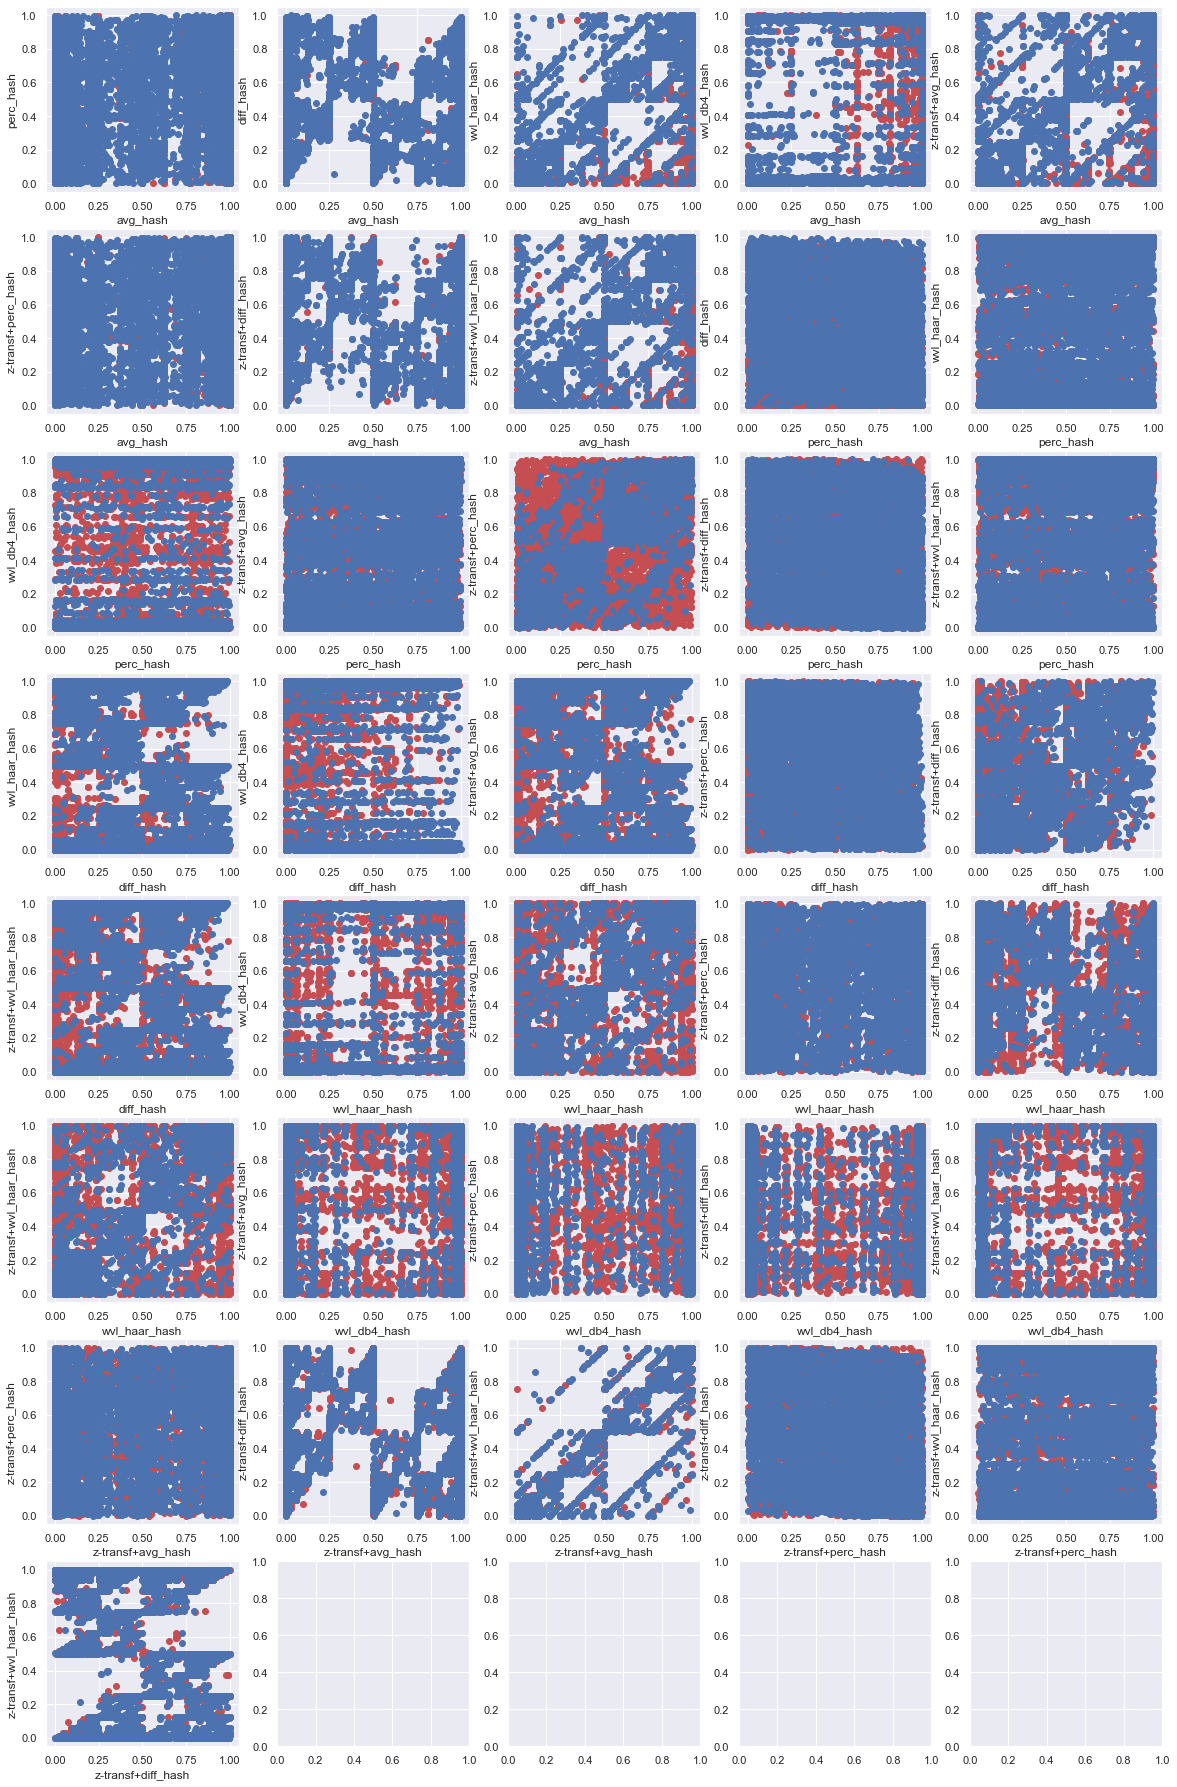

In [12]:
# PLOT DATA 
random_state=123
# X_pca=X.copy() # by-pass
n_components = nfeat-1 # because two wavelets are equals (last two features. I keep only one)

nplots=int(n_components*(n_components-1)/2+0.9)
ncols=5
nrows=int(nplots/ncols+0.9)
nS=int(nSamples/2)

fig, axs = plt.subplots(nrows,ncols, figsize=(4*ncols, 4*nrows))

ctr=0
for i in range(n_components-1):
    for j in range(i+1,n_components):
        r=int(ctr/ncols)
        c=ctr-r*ncols
#         print("n",ctr,"r",r,"c",c)
        axs[r,c].plot(X[:nS,i], X[:nS,j],'ro') # class 0
        axs[r,c].plot(X[nS:,i], X[nS:,j],'bo') # class 1
        axs[r,c].set_xlabel(concrete_features[i])
        axs[r,c].set_ylabel(concrete_features[j])
        ctr+=1
        
plt.show()

In [13]:
# get a list of models to evaluate
def get_models():
    models = list()
    models.append(LogisticRegression())
    models.append(RidgeClassifier())
    models.append(SGDClassifier())
    models.append(PassiveAggressiveClassifier())
    models.append(KNeighborsClassifier())
    models.append(DecisionTreeClassifier())
    models.append(ExtraTreeClassifier())
    models.append(LinearSVC())
    models.append(SVC())
    models.append(GaussianNB())
    models.append(AdaBoostClassifier())
    models.append(BaggingClassifier())
    models.append(RandomForestClassifier())
    models.append(ExtraTreesClassifier())
    models.append(GradientBoostingClassifier())
    models.append(LinearDiscriminantAnalysis())
    models.append(QuadraticDiscriminantAnalysis())
#     models.append(GaussianProcessClassifier())    # too slow and not he best !!!
    return models

In [14]:
# MODIFIED ->  evaluate the model using a given test condition
# inputs: cv = test conditions, model=model, X, y = data and labels, metric = metric

def evaluate_model(cv, model, X, y, metric):
    
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    
    # return scores
    return mean(scores)
 


1>LogisticRegression:, cv=0.840
2>RidgeClassifier:, cv=0.838
3>SGDClassifier:, cv=0.834
4>PassiveAggressiveClassifier:, cv=0.743
5>KNeighborsClassifier:, cv=0.883
6>DecisionTreeClassifier:, cv=0.897
7>ExtraTreeClassifier:, cv=0.864
8>LinearSVC:, cv=0.839
9>SVC:, cv=0.883
10>GaussianNB:, cv=0.697
11>AdaBoostClassifier:, cv=0.898
12>BaggingClassifier:, cv=0.928
13>RandomForestClassifier:, cv=0.940
14>ExtraTreesClassifier:, cv=0.937
15>GradientBoostingClassifier:, cv=0.923
16>LinearDiscriminantAnalysis:, cv=0.838
17>QuadraticDiscriminantAnalysis:, cv=0.829
best classifier  RandomForestClassifier() accuracy 0.9396


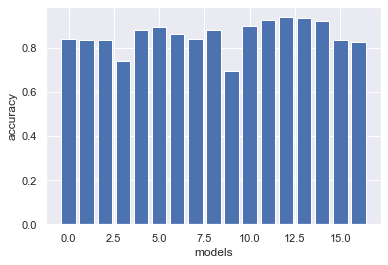

In [15]:
# MAIN PROGRAM

#selected number of features
sel_feat=n_components

# define test conditions

n_splits=5

cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# get the list of models to consider
models = get_models()

# set lists to collect results
cv_results = list()

# evaluate each model

metric='accuracy'   

ctr=1
for model in models:
    
    # evaluate model using each test condition
    cv_mean = evaluate_model(cv, model, X[:,:sel_feat], Y, metric)
    
    # check for invalid results
    if isnan(cv_mean): 
        continue
        
    # store results
    cv_results.append(cv_mean)
   
    # summarize progress
    print('%d>%s:, cv=%.3f' % (ctr,type(model).__name__, cv_mean))
    ctr+=1

ord_index=np.argsort(cv_results)

model=models[ord_index[-1]]
print("best classifier ",model,metric,round(cv_results[ord_index[-1]],4))

plt.bar(np.arange(len(models)),cv_results)
# plt.bar(np.arange(len(models)),results)
plt.xlabel('models')
plt.ylabel(metric)
plt.show()



In [16]:
# SEQUENTIAL FEATURE SELECTION 

best_features_index=[]
best_features_name=[]

max_score=-1

for n_features_to_select in range(2,10): #=3 # WE ASK TO GET ONLY 5 BETTER

    # # number of feature combinations 
    # ncombs=1
    # if sel_feat<n_components:
    #     ncombs = math.factorial(n_components)/math.factorial(n_components-sel_feat)/math.factorial(sel_feat)    
    # print(ncombs)    

    sfs = SequentialFeatureSelector(estimator=model, n_features_to_select=n_features_to_select).fit(X, Y)

    X_sel=sfs.transform(X)

    selected=sfs.get_support()

    sel_features=[]

    for f in range(nfeat):
        if selected[f]:
            sel_features.append(concrete_features[f])

    print("selected features: ",sel_features)
    scores = cross_val_score(model, X_sel, Y, scoring='accuracy', cv=cv, n_jobs=-1)
    print("average score: ",round(np.mean(scores),4)," (",round(np.std(scores),4),")")
    
    if max_score<np.mean(scores):
        max_score=np.mean(scores)
        best_features_index=selected
        best_features_name=sel_features

    #20K inages
# selected features:  ['avg_hash', 'wvl_haar_hash']
# average score:  0.9121  ( 0.0055 )
# selected features:  ['avg_hash', 'diff_hash', 'wvl_haar_hash']
# average score:  0.9323  ( 0.0017 )
# selected features:  ['avg_hash', 'diff_hash', 'wvl_haar_hash', 'wvl_db4_hash']
# average score:  0.935  ( 0.0037 )
# selected features:  ['avg_hash', 'perc_hash', 'diff_hash', 'wvl_haar_hash', 'wvl_db4_hash']
# average score:  0.9366  ( 0.0044 )
# selected features:  ['avg_hash', 'perc_hash', 'diff_hash', 'wvl_haar_hash', 'wvl_db4_hash', 'z-transf+avg_hash']
# average score:  0.9386  ( 0.0038 )
# selected features:  ['avg_hash', 'perc_hash', 'diff_hash', 'wvl_haar_hash', 'wvl_db4_hash', 'z-transf+perc_hash', 'z-transf+wvl_haar_hash']
# average score:  0.9396  ( 0.0037 )
# selected features:  ['avg_hash', 'perc_hash', 'diff_hash', 'wvl_haar_hash', 'wvl_db4_hash', 'z-transf+perc_hash', 'z-transf+diff_hash', 'z-transf+wvl_haar_hash']
# average score:  0.9391  ( 0.0037 )
# selected features:  ['avg_hash', 'perc_hash', 'diff_hash', 'wvl_haar_hash', 'wvl_db4_hash', 'z-transf+avg_hash', 'z-transf+perc_hash', 'z-transf+wvl_haar_hash', 'z-transf+wvl_db4_hash']
# average score:  0.9403  ( 0.0023 )

selected features:  ['avg_hash', 'wvl_haar_hash']
average score:  0.9121  ( 0.0055 )
selected features:  ['avg_hash', 'diff_hash', 'wvl_haar_hash']
average score:  0.9323  ( 0.0017 )
selected features:  ['avg_hash', 'diff_hash', 'wvl_haar_hash', 'wvl_db4_hash']
average score:  0.935  ( 0.0037 )
selected features:  ['avg_hash', 'perc_hash', 'diff_hash', 'wvl_haar_hash', 'wvl_db4_hash']
average score:  0.9366  ( 0.0044 )
selected features:  ['avg_hash', 'perc_hash', 'diff_hash', 'wvl_haar_hash', 'wvl_db4_hash', 'z-transf+avg_hash']
average score:  0.9386  ( 0.0038 )
selected features:  ['avg_hash', 'perc_hash', 'diff_hash', 'wvl_haar_hash', 'wvl_db4_hash', 'z-transf+perc_hash', 'z-transf+wvl_haar_hash']
average score:  0.9396  ( 0.0037 )
selected features:  ['avg_hash', 'perc_hash', 'diff_hash', 'wvl_haar_hash', 'wvl_db4_hash', 'z-transf+perc_hash', 'z-transf+diff_hash', 'z-transf+wvl_haar_hash']
average score:  0.9391  ( 0.0037 )
selected features:  ['avg_hash', 'perc_hash', 'diff_hash'

Confusion matrix on training data:
[[2905  234]
 [ 130 2731]]


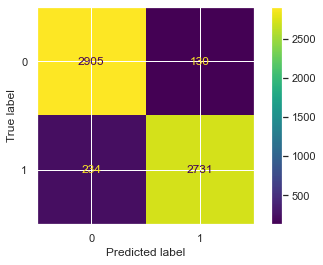

In [21]:
# Declare a classifier class with the best model and best features
Model = model

# Fit the model with training data and target values
Model.fit(X_train, Y_train)

# Check with test data if everything is ok
Y_pred = Model.predict(X_test)
conf =  confusion_matrix(Y_pred,Y_test)
print("Confusion matrix on training data:")
print(conf)
plot_confusion_matrix(Model, X_test, Y_test)  
plt.show()


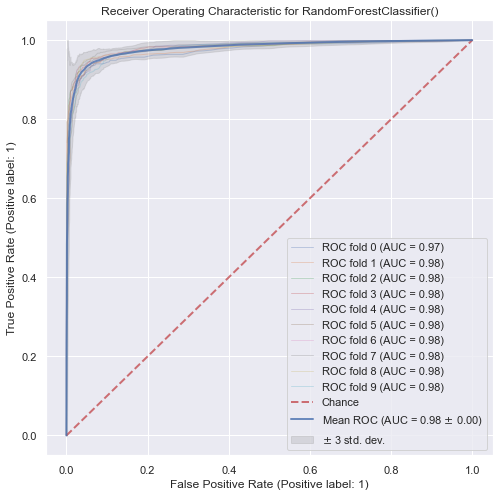

In [29]:
# ROC AUC with k-fold cross-validation

n_splits = 10

cv = StratifiedKFold(n_splits=n_splits)
classifier = Model

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, nSamples)

fig, ax = plt.subplots(figsize=(8,8))
for i, (train, test) in enumerate(cv.split(X, Y)):
    classifier.fit(X[train], Y[train])
    viz = plot_roc_curve(classifier, X[test], Y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 3*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 3*std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 3 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic for "+str(model))
ax.legend(loc="lower right")
plt.show()

In [30]:
# create test data set

# features are obtained applying the same procedure as for train data

Xpos=[]
Ypos=[]
for file in tqdm(PosFiles[HNSAMPLES:]):
    path=os.path.join(POSITIVE_PATH, file)
    Ypos.append(1)
    Xpos.append([])
    Xpos[-1].append([(HashFuncCallers(path)) for name, HashFuncCallers in HashFuncCallers])

xpos=np.array(Xpos).reshape(np.asarray(Xpos).shape[0],np.asarray(Xpos).shape[2])
# print(path, ',',xpos.shape)

print()
Xneg=[]
Yneg=[]
for file in tqdm(NegFiles[HNSAMPLES:]):
    path=os.path.join(NEGATIVE_PATH, file)
    Yneg.append(0)
    Xneg.append([])
    Xneg[-1].append([(HashFuncCallers(path)) for name, HashFuncCallers in HashFuncCallers])

xneg=np.array(Xneg).reshape(np.asarray(Xneg).shape[0],np.asarray(Xneg).shape[2])

X_t=np.concatenate((xpos,xneg))

Y_test=np.concatenate((Ypos,Yneg))



  0%|                                                                                | 2/10000 [00:00<09:10, 18.17it/s]

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:44<00:00, 21.54it/s]


Confusion matrix on test data:
[[9578 1406]
 [ 422 8594]]


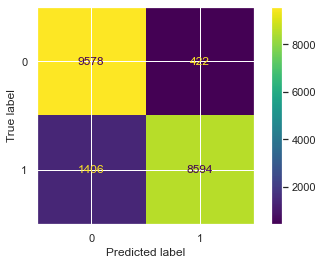

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     10000
           1       0.95      0.86      0.90     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



In [39]:
X_t=np.concatenate((xpos,xneg))
nSamples=X_t.shape[0]
nfeat=X_t.shape[1]

# transformation of image hash dataset into float matrix
X_test=np.zeros((nSamples,nfeat),dtype=float)
for s in range(nSamples):
    for f in range(nfeat):
        X_test[s,f]=float(int(str(X_t[s,f]),16))

scaler=MinMaxScaler()
scaler.fit(X_test)
X_test=scaler.transform(X_test) 

# Check with test data if everything is ok
Y_pred = classifier.predict(X_test)
conf =  confusion_matrix(Y_pred,Y_test)
print("Confusion matrix on test data:")
print(conf)
plot_confusion_matrix(classifier, X_test, Y_test)  
plt.show()

print(classification_report(Y_test,Y_pred))


In [ ]:
# CLASSIFICATION METRICS 

# BINARY CLASSIFICATION ONLY

# precision_recall_curve(y_true, probas_pred, *) Compute precision-recall pairs for different probability thresholds.

# roc_curve(y_true, y_score, *[, pos_label, …]) Compute Receiver operating characteristic (ROC).

# det_curve(y_true, y_score[, pos_label, …]) Compute error rates for different probability thresholds.


# MULTICLASS CASE:

# balanced_accuracy_score(y_true, y_pred, *[, …]) Compute the balanced accuracy.

# cohen_kappa_score(y1, y2, *[, labels, …]) Cohen’s kappa: a statistic that measures inter-annotator agreement.

# confusion_matrix(y_true, y_pred, *[, …]) Compute confusion matrix to evaluate the accuracy of a classification.

# hinge_loss(y_true, pred_decision, *[, …]) Average hinge loss (non-regularized).

# matthews_corrcoef(y_true, y_pred, *[, …]) Compute the Matthews correlation coefficient (MCC).

# roc_auc_score(y_true, y_score, *[, average, …]) Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

# top_k_accuracy_score(y_true, y_score, *[, …]) Top-k Accuracy classification score.

# MULTILABEL CASE:

# accuracy_score(y_true, y_pred, *[, …]) Accuracy classification score.

# classification_report(y_true, y_pred, *[, …]) Build a text report showing the main classification metrics.

# f1_score(y_true, y_pred, *[, labels, …]) Compute the F1 score, also known as balanced F-score or F-measure.

# fbeta_score(y_true, y_pred, *, beta[, …]) Compute the F-beta score.

# hamming_loss(y_true, y_pred, *[, sample_weight]) Compute the average Hamming loss.

# jaccard_score(y_true, y_pred, *[, labels, …]) Jaccard similarity coefficient score.

# log_loss(y_true, y_pred, *[, eps, …]) Log loss, aka logistic loss or cross-entropy loss.

# multilabel_confusion_matrix(y_true, y_pred, *) Compute a confusion matrix for each class or sample.

# precision_recall_fscore_support(y_true, …) Compute precision, recall, F-measure and support for each class.

# precision_score(y_true, y_pred, *[, labels, …]) Compute the precision.

# recall_score(y_true, y_pred, *[, labels, …]) Compute the recall.

# roc_auc_score(y_true, y_score, *[, average, …]) Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

# zero_one_loss(y_true, y_pred, *[, …])  Zero-one classification loss.